In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,BatchNormalization,Flatten,Conv2D,MaxPool2D
from keras.callbacks import ReduceLROnPlateau,Callback,EarlyStopping,ModelCheckpoint
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix,classification_report

2023-07-04 21:41:08.720074: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 21:41:08.739393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 21:41:08.825652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 21:41:08.826111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 21:41:09.427101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
from glob import glob

In [3]:
glob('*')

['untitled1.py',
 'checkpoint',
 'untitled3.py',
 'digit recognition.ipynb',
 'fire_checkpoint.data-00000-of-00001',
 'fire.ipynb',
 'untitled.py',
 'submission.csv',
 'test.csv',
 'untitled2.py',
 'fire_checkpoint.index',
 'train.csv',
 'fire_dataset',
 'submission1.csv']

In [4]:
glob('fire_dataset/*')

['fire_dataset/fire_images', 'fire_dataset/non_fire_images']

In [5]:
fire=pd.DataFrame({'path':glob('fire_dataset/fire_images/*')})
nfire=pd.DataFrame({'path':glob('fire_dataset/non_fire_images/*')})

In [6]:
fire

,path
0,fire_dataset/fire_images/fire.186.png
1,fire_dataset/fire_images/fire.166.png
2,fire_dataset/fire_images/fire.483.png
3,fire_dataset/fire_images/fire.256.png
4,fire_dataset/fire_images/fire.745.png
...,...
750,fire_dataset/fire_images/fire.240.png
751,fire_dataset/fire_images/fire.597.png
752,fire_dataset/fire_images/fire.250.png
753,fire_dataset/fire_images/fire.225.png


In [7]:
nfire

,path
0,fire_dataset/non_fire_images/non_fire.166.png
1,fire_dataset/non_fire_images/non_fire.106.png
2,fire_dataset/non_fire_images/non_fire.48.png
3,fire_dataset/non_fire_images/non_fire.243.png
4,fire_dataset/non_fire_images/non_fire.203.png
...,...
239,fire_dataset/non_fire_images/non_fire.4.png
240,fire_dataset/non_fire_images/non_fire.194.png
241,fire_dataset/non_fire_images/non_fire.227.png
242,fire_dataset/non_fire_images/non_fire.178.png


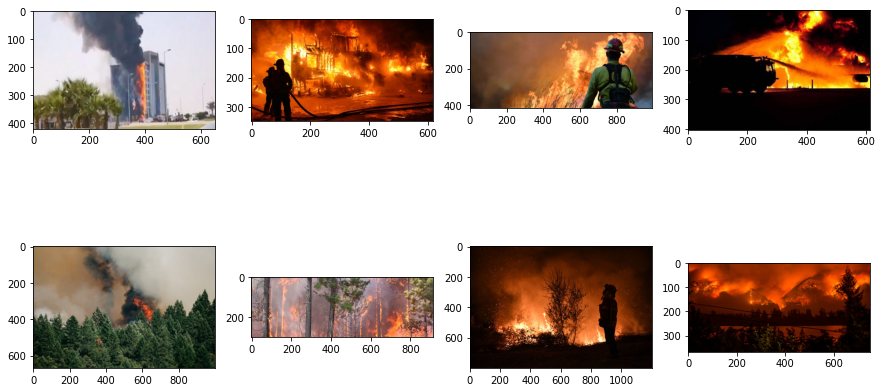

In [8]:
from PIL import Image

fig,ax=plt.subplots(2,4,figsize=(15,8))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(Image.open(fire.path[i]))
    


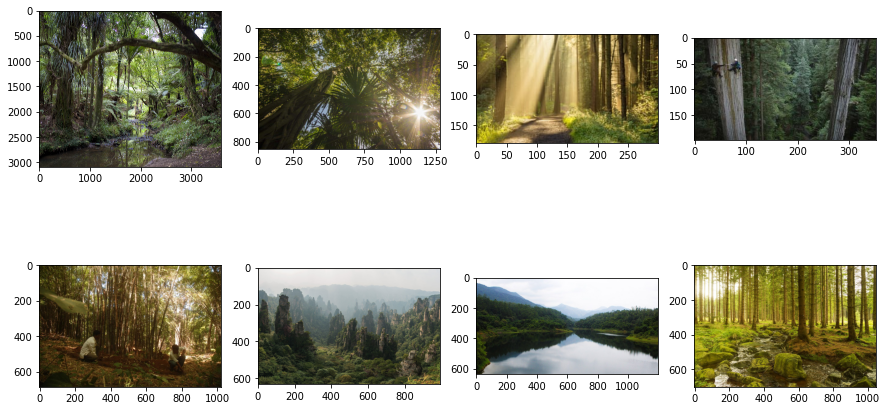

In [9]:
fig,ax=plt.subplots(2,4,figsize=(15,8))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(Image.open(nfire.path[i]))
    

In [10]:
fire['label']='fire'
nfire['label']='no_fire'

In [11]:
df=pd.concat([fire,nfire],axis=0)

label
fire       755
no_fire    244
Name: count, dtype: int64

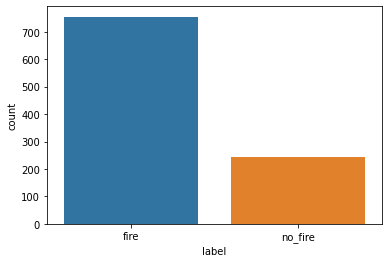

In [12]:
sns.countplot(x=df.label)
df.label.value_counts()

In [13]:
train_df,test_df=train_test_split(df,test_size=0.2,shuffle=True,stratify=df.label,random_state=8)

In [14]:
print(train_df.label.value_counts())
print(f'nfire : {sum(train_df.label==0)/len(train_df)}')
print(f'fire : {sum(train_df.label==1)/len(train_df)}')

label
fire       604
no_fire    195
Name: count, dtype: int64
nfire : 0.0
fire : 0.0


In [15]:
print(test_df.label.value_counts())
print(f'nfire : {sum(test_df.label==0)/len(test_df)}')
print(f'fire : {sum(test_df.label==1)/len(test_df)}')

label
fire       151
no_fire     49
Name: count, dtype: int64
nfire : 0.0
fire : 0.0


In [16]:
datagen=ImageDataGenerator(
featurewise_center=False,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True,
rescale=1/255.,
validation_split=0.2)

train=datagen.flow_from_dataframe(dataframe=train_df,x_col='path',y_col='label',batch_size=8,target_size=(224,224),
                                 color_mode='rgb',class_mode='binary',shuffle=True,
                                 subset='training',seed=8)
val=datagen.flow_from_dataframe(dataframe=train_df,x_col='path',y_col='label',batch_size=8,target_size=(224,224),
                                 color_mode='rgb',class_mode='binary',shuffle=True,
                                 subset='validation',seed=8)


datagen_t=ImageDataGenerator(
featurewise_center=False,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True,
rescale=1/255.)

test=datagen.flow_from_dataframe(dataframe=test_df,x_col='path',y_col='label',batch_size=8,target_size=(224,224),
                                 color_mode='rgb',class_mode='binary',shuffle=True,
                                seed=8)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


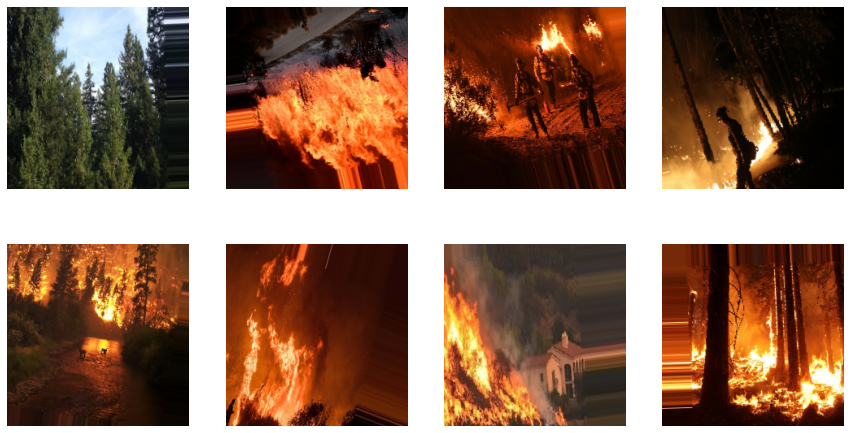

In [17]:
fig,ax=plt.subplots(2,4,figsize=(15,8))
ax=ax.flatten()
for i in range(8):
    ax[i].imshow(train[0][0][i])
    ax[i].axis('off')

In [18]:
batchsize=8
epochs=50


In [19]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [20]:
optimizer=RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',])

In [21]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                        patience=3,
                                        factor=0.5,
                                        mini_lr=0.00001)

In [22]:
checkpoint_path = "fire_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [23]:
history=model.fit(train,epochs=epochs,validation_data=val,
                 callbacks=[learning_rate_reduction,early_stopping,
                            checkpoint_callback,
])

2023-07-04 21:41:13.258279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 3.1539 - accuracy: 0.7828

2023-07-04 21:41:51.317324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 42s 513ms/step - loss: 3.1539 - accuracy: 0.7828 - val_loss: 0.3675 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 42s 525ms/step - loss: 0.4807 - accuracy: 0.8422 - val_loss: 0.3954 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 40s 497ms/step - loss: 0.4759 - accuracy: 0.8500 - val_loss: 0.5973 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - 40s 494ms/step - loss: 0.5922 - accuracy: 0.8344 - val_loss: 0.5544 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 39s 487ms/step - loss: 0.4867 - accuracy: 0.8547 - val_loss: 0.3418 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 6/50
80/80 [==============================] - 40s 493ms/step - loss: 0.4418 - accuracy: 0.8766 - val_loss: 0.2850 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 7/50
80/80 [==============================] - 39s 484ms/step - loss: 

In [24]:
from keras.applications import Xception
from tensorflow.keras.models import Model

xception=Xception(include_top=False,input_shape=(224,224,3))
input_to_model=xception.input
xception.trainable=False

x=Flatten()(xception.output)
x=Dense(256,activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model1=Model(inputs=input_to_model,outputs=output)

In [25]:
from tensorflow.keras.metrics import Recall,AUC

model1.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])
history1=model1.fit(train,epochs=epochs,validation_data=val,
                 callbacks=[learning_rate_reduction,early_stopping,
                            checkpoint_callback,
])

2023-07-04 21:49:48.544401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 2.0066 - accuracy: 0.8938 - recall: 0.7770 - auc: 0.8657

2023-07-04 21:50:13.311282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 30s 357ms/step - loss: 2.0066 - accuracy: 0.8938 - recall: 0.7770 - auc: 0.8657 - val_loss: 0.6517 - val_accuracy: 0.9308 - val_recall: 0.9787 - val_auc: 0.9662 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 28s 352ms/step - loss: 0.6695 - accuracy: 0.9141 - recall: 0.8041 - auc: 0.9189 - val_loss: 0.5772 - val_accuracy: 0.8868 - val_recall: 0.8936 - val_auc: 0.9334 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 29s 357ms/step - loss: 0.3474 - accuracy: 0.9109 - recall: 0.8108 - auc: 0.9528 - val_loss: 0.2662 - val_accuracy: 0.9497 - val_recall: 0.8511 - val_auc: 0.9575 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - 28s 344ms/step - loss: 0.1643 - accuracy: 0.9563 - recall: 0.8919 - auc: 0.9758 - val_loss: 0.1843 - val_accuracy: 0.9245 - val_recall: 0.8723 - val_auc: 0.9793 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 29s 366ms/step - loss: 0.1632 - accuracy: 0.9469 - reca

In [26]:
result=model.evaluate(test)
result1=model1.evaluate(test)

print(result)
print(result1)

2023-07-04 21:54:35.006636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 3s 100ms/step - loss: 0.2489 - accuracy: 0.9150


2023-07-04 21:54:37.765653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 5s 207ms/step - loss: 0.1189 - accuracy: 0.9600 - recall: 0.9796 - auc: 0.9925
[0.24888405203819275, 0.9150000214576721]
[0.11892810463905334, 0.9599999785423279, 0.9795918464660645, 0.9924988746643066]
